## Webscrapping: IMDB Action Movie Reviews
#### Author: Kevin Okiah
#### 02/27/2019

The focus of this notebook is to demonstate how to go about scrapping movie reviews, and rating from imdb. Reviews scrapped on  this Notebook will be used down the line for clustering and topic modeling.

one positive and one negative review are scrapped for 190 movies  for a total of ~ 380 reviews. For this analysis, a positive review is considered to be a review with a review rating of greater than 7/10 where as a negative review is a review with a rating less than 5/10.

Some basic EDA and data visualization is performed on the ratings for the movies.

The reviews collected are then cleaned following the same text cleaning approaches discuss discussed in previous notebooks leveraging `TextCleaningToolkit.py`. The review preprocessing approach includes:

1. Break review into sentences/lines
2. Change sentences to lower case
3. Expland contractions for each sentence. Turning shortforms like Can't to Can not
4. NP Chunk from pattern.en import parsetree 
5. Break lines into tokens
6. Remove punctuation marks
7. remove stopwords
8. Perform lemmatization


I wrap up this notebook by chunking  the reviews using pattern

**Tools Used**
* Selenium
* BeautifulSoup
* NLTK
* urllib
* lxml
* spacy

In [1]:
import numpy as np
import pandas as pd
import selenium
from lxml import html
import urllib3
from bs4 import BeautifulSoup
import lxml
import urllib 
import nltk
import string
import request
#from urllib import request
import urllib
from pyvirtualdisplay import Display
from selenium import webdriver  #We will use selenimun to navigate between pages
import warnings
warnings.filterwarnings("ignore")
import pickle
import time 
import spacy
spacy.prefer_gpu()
#!python -m spacy download en   ## download models
nlp = spacy.load('en')
import seaborn as sns
import matplotlib.pyplot as plt
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import WebDriverException, NoSuchElementException
from IPython.display import display, HTML
from TextCleaningToolkit import *
%matplotlib inline

display = Display(visible=0, size=(800, 600))
display.start()
driver = webdriver.Chrome()


%matplotlib inline

http = urllib3.PoolManager()

def get_url_Bs(url):
    tree = BeautifulSoup(url)
    return tree

def get_url_Sel(url):
    tree = html.document_fromstring(url)
    return tree

base_url ='https://www.imdb.com'


1.	Compile a list of static links (permalinks) to individual user movie reviews from one particular website. This will be your working dataset for this assignment, as well as for assignments 7 and 8, which together will make up your semester project.

>a.	It does not matter if you use a crawler or if you manually collect the links, but you will need at least 100 movie review links. Note that, as of this writing, the robots.txt file of IMDB.com allows the crawling of user reviews.

>b.	Each link should be to a web page that has only one user review of only one movie, e.g., the user review permalinks on the IMDB site.

>c.	Choose reviews of movies that are all in the same genre, e.g., sci-fi, mystery, romance, superhero, etc. 

>d.	Make sure your collection includes reviews of several movies in your chosen genre and that it includes a mix of negative and positive reviews.  



**Scrapping Approach**

For my scrappying, I chose to scrape actions movies from url "https://www.imdb.com/search/title?title_type=feature&user_rating=3.5,&num_votes=10000,&genres=action&sort=user_rating,desc". This filter returns 1,813 action movies titles with IMDB rating >3.5 and number of votes >10000. This gives me the flexiblity to select best and worst movies based on IMDB rating and also to have some data to perform some visualisation as shown below. After pulling the movie list, I saved it in an pandas objectto avoid having to rerun the query which could take a while.

In [2]:
next_page ='//*[contains(concat( " ", @class, " " ), concat( " ", "next-page", " " ))]' #xpath for next page

In [3]:
def get_MoviesUrls(max_page =37,imdb_actions_all_movies_list="https://www.imdb.com/search/title?title_type=feature&user_rating=3.5,&num_votes=10000,&genres=action&sort=user_rating,desc" ):
    '''
    Functions Get Pages for Urls for movies
    max_page = max number of pages to parse. each page = 50 movies for a total of 1800 movies
    
    ** Feature Film, Rating Count at least 10,000, Action (Sorted by IMDb Rating Ascending), user Rating> 3.5
    imdb_actions_all_movies_list = "https://www.imdb.com/search/title?title_type=feature&num_votes=10000,
    &genres=action&sort=user_rating,asc"

    '''

    driver.get(imdb_actions_all_movies_list) # access the base url
    
    movies_urls = [] #list of all urls

    for i in range(max_page):
        try:
            driver.set_page_load_timeout(3)
            Current_Page_url = driver.current_url #get url for the current page
            myurl = http.request('GET', Current_Page_url).data
            tree = get_url_Sel(myurl)
            links = tree.xpath('//a/@href') # links to one page
            '''
            #pulling urls for movies form one page
            1. one page as 50 movies
            2. Url for a movie_page starts with '/title' and ends with either '=adv_li_tt' or '=adv_li_i'
            '''
            for i in links:
                if i.startswith('/title') & i.endswith('=adv_li_tt'):
                    print(base_url+i)
                    movies_urls =movies_urls+ [base_url+i]  #append the reconstruct movie page url to movies list
            driver.find_element_by_xpath(next_page).click() #click next button
            time.sleep(3) # adding a wait time to ensure th page loads

        except request.HTTPError as err:
            if err.code == 404:
                print(err.code, " Error!!!")
            else:
                raise
        except TimeoutException  as e:
            isrunning = 0
            #print("Exception has been thrown. " + str(e))
            print("TimeoutException!!  ", str(e))
        except WebDriverException  as wb:
            isrunning = 0
            #print("Exception has been thrown. " + str(e))
            print("WebDirverException!!  ", str(wb))
    return(movies_urls)

movies_urls = get_MoviesUrls()# commented out so us not to rerun it multipletimes
pickle.dump(movies_urls, open( "movies_url.p", "wb" ) , protocol=2) # save list as pickle

In [5]:
with open('movies_url.p', 'rb') as f:
     movies_urls = pickle.load(f)

In [6]:
len(movies_urls)

1810

## IMDB Rating

In [7]:
def get_Movie_Reviews_urls_and_imdbRating(Movies_Urls=movies_urls):#[1171:1850]):
    '''
    Function tracks a movies IMDBRating and returns urls review pages.
    
    We will use the imdb rating to select the worst movies and good movies to pull reviews
    '''
    Titles =[]
    Movie_Url =[]
    Reviews_url =[]
    imdbRating = []
    NumberofVotes =[]
    Movies_ReviewsPages = {}
    Metascore = []
    metacore_xpath ='//*[contains(concat( " ", @class, " " ), concat( " ", "titleReviewBarItem", " " ))]'
    for movie in Movies_Urls:
        try:
            driver.get(movie) #get page for a given movie
            imdbRaT= driver.find_element_by_class_name('imdbRating').text.splitlines()[0].split('/')[0]
            Votes =driver.find_element_by_class_name('imdbRating').text.splitlines()[1]
            try:
                metascore =int(driver.find_element_by_xpath(metacore_xpath).text.split()[0])
            except NoSuchElementException  as f:
                print("NoSuchElementException!!  ", str(f))
                metascore ='NA'
            except ValueError:
                metascore ='NA'
            imdbRating =imdbRating + [imdbRaT]
            NumberofVotes =  NumberofVotes+[Votes ]
            Title = driver.title #movie title
            Titles = Titles+[Title]
            Movie_Url = Movie_Url+ [movie]
            review_url =movie.split('?ref')[0]+'reviews?ref_=tt_ql_3'
            Reviews_url =Reviews_url +[review_url]
            Metascore =  Metascore + [metascore]
            time.sleep(3)
            print(review_url)
        except request.HTTPError as err:
            if err.code == 404:
                print(err.code, " Error!!!")
            else:
                raise
        except TimeoutException  as e:
            isrunning = 0
            #print("Exception has been thrown. " + str(e))
            print("TimeoutException!!  ", str(e))
        except WebDriverException  as wb:
            isrunning = 0
            #print("Exception has been thrown. " + str(e))
            print("WebDirverException!!  ", str(wb))
    Movies_ReviewsPages.update({'Title': Titles, 'imdbRating':imdbRating,'NumberofVotes':NumberofVotes,
                                'MetaScore':Metascore,'Movie Page':  Movie_Url, "Movie's Review Page": Reviews_url})

    return(pd.DataFrame.from_dict(Movies_ReviewsPages))


##### data save in pickle to avoid rerunning this bloack of code
Movies_RatingsA = get_Movie_Reviews_urls_and_imdbRating()
pickle.dump(Movies_RatingsA, open( "Movies_RatingsA.p", "wb" ), protocol=2 ) # save dataframe as pickle

## Data Visualisation

In this section I perform some basic EDA and Data visualization of imdbRating, NumberofVotes , Metascore and create some binning features to visualize the movie rating

In [8]:
# reaload picked data          
with open('Movies_RatingsA.p', 'rb') as f:
     Movies_RatingsA = pickle.load(f)

Movies_RatingsA

,Title,imdbRating,NumberofVotes,MetaScore,Movie Page,Movie's Review Page
0,The Mountain II (2016) - IMDb,9.3,"99,822",NA,https://www.imdb.com/title/tt5813916/?ref_=adv...,https://www.imdb.com/title/tt5813916/reviews?r...
1,The Dark Knight (2008) - IMDb,9.0,"2,025,570",84,https://www.imdb.com/title/tt0468569/?ref_=adv...,https://www.imdb.com/title/tt0468569/reviews?r...
2,Vikram Vedha (2017) - IMDb,8.8,"17,684",NA,https://www.imdb.com/title/tt6148156/?ref_=adv...,https://www.imdb.com/title/tt6148156/reviews?r...
3,Inception (2010) - IMDb,8.8,"1,804,838",74,https://www.imdb.com/title/tt1375666/?ref_=adv...,https://www.imdb.com/title/tt1375666/reviews?r...
4,Star Wars: Episode V - The Empire Strikes Back...,8.8,"1,033,505",82,https://www.imdb.com/title/tt0080684/?ref_=adv...,https://www.imdb.com/title/tt0080684/reviews?r...
5,The Matrix (1999) - IMDb,8.7,"1,478,881",73,https://www.imdb.com/title/tt0133093/?ref_=adv...,https://www.imdb.com/title/tt0133093/reviews?r...
6,Harakiri (1962) - IMDb,8.7,"23,879",NA,https://www.imdb.com/title/tt0056058/?ref_=adv...,https://www.imdb.com/title/tt0056058/reviews?r...
7,Rangasthalam (2018) - IMDb,8.6,"14,938",NA,https://www.imdb.com/title/tt7392212/?ref_=adv...,https://www.imdb.com/title/tt7392212/reviews?r...
8,Spider-Man: Into the Spider-Verse (2018) - IMDb,8.6,"126,704",87,https://www.imdb.com/title/tt4633694/?ref_=adv...,https://www.imdb.com/title/tt4633694/reviews?r...
9,Black Friday (2004) - IMDb,8.6,"15,867",76,https://www.imdb.com/title/tt0400234/?ref_=adv...,https://www.imdb.com/title/tt0400234/reviews?r...


In [9]:
Movies_Ratings = Movies_RatingsA.copy()

In [10]:
Movies_Ratings.dtypes

Title                  object
imdbRating             object
NumberofVotes          object
MetaScore              object
Movie Page             object
Movie's Review Page    object
dtype: object

In [11]:
# replace mising Metascore with -1 and convert data types for imdbratin, Metascore and Number of votes fo numeric.

Movies_Ratings.imdbRating = Movies_Ratings.imdbRating.astype(float)
Movies_Ratings.MetaScore= Movies_Ratings.MetaScore.replace(to_replace='NA', value=-1, inplace=False).astype(int)
Movies_Ratings.NumberofVotes =Movies_Ratings.NumberofVotes.str.replace(',', '').astype(int)

In [12]:
Movies_Ratings.dtypes

Title                   object
imdbRating             float64
NumberofVotes            int64
MetaScore                int64
Movie Page              object
Movie's Review Page     object
dtype: object

In [13]:
Movies_Ratings.head()

,Title,imdbRating,NumberofVotes,MetaScore,Movie Page,Movie's Review Page
0,The Mountain II (2016) - IMDb,9.3,99822,-1,https://www.imdb.com/title/tt5813916/?ref_=adv...,https://www.imdb.com/title/tt5813916/reviews?r...
1,The Dark Knight (2008) - IMDb,9.0,2025570,84,https://www.imdb.com/title/tt0468569/?ref_=adv...,https://www.imdb.com/title/tt0468569/reviews?r...
2,Vikram Vedha (2017) - IMDb,8.8,17684,-1,https://www.imdb.com/title/tt6148156/?ref_=adv...,https://www.imdb.com/title/tt6148156/reviews?r...
3,Inception (2010) - IMDb,8.8,1804838,74,https://www.imdb.com/title/tt1375666/?ref_=adv...,https://www.imdb.com/title/tt1375666/reviews?r...
4,Star Wars: Episode V - The Empire Strikes Back...,8.8,1033505,82,https://www.imdb.com/title/tt0080684/?ref_=adv...,https://www.imdb.com/title/tt0080684/reviews?r...


In [14]:
np.unique(Movies_Ratings.imdbRating)

array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ,
       6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6,
       8.7, 8.8, 9. , 9.3])

In [15]:
#Create binning features for imdb Rating and Metascore
bins = pd.IntervalIndex.from_tuples([(3.5, 5), (5, 6), (6, 7.5), (7.5, 10)])
Movies_Ratings = Movies_Ratings.assign(imdbRating_bins = pd.cut(np.array(Movies_Ratings['imdbRating']), 
                                              bins))
Movies_Ratings = Movies_Ratings.assign(MetaScore_bins = pd.cut(np.array(Movies_Ratings['MetaScore']), 
                                              4, labels =['<25', '25-50', '50-75', '75-100']))

In [16]:
Movies_Ratings.head()

,Title,imdbRating,NumberofVotes,MetaScore,Movie Page,Movie's Review Page,imdbRating_bins,MetaScore_bins
0,The Mountain II (2016) - IMDb,9.3,99822,-1,https://www.imdb.com/title/tt5813916/?ref_=adv...,https://www.imdb.com/title/tt5813916/reviews?r...,"(7.5, 10.0]",<25
1,The Dark Knight (2008) - IMDb,9.0,2025570,84,https://www.imdb.com/title/tt0468569/?ref_=adv...,https://www.imdb.com/title/tt0468569/reviews?r...,"(7.5, 10.0]",75-100
2,Vikram Vedha (2017) - IMDb,8.8,17684,-1,https://www.imdb.com/title/tt6148156/?ref_=adv...,https://www.imdb.com/title/tt6148156/reviews?r...,"(7.5, 10.0]",<25
3,Inception (2010) - IMDb,8.8,1804838,74,https://www.imdb.com/title/tt1375666/?ref_=adv...,https://www.imdb.com/title/tt1375666/reviews?r...,"(7.5, 10.0]",75-100
4,Star Wars: Episode V - The Empire Strikes Back...,8.8,1033505,82,https://www.imdb.com/title/tt0080684/?ref_=adv...,https://www.imdb.com/title/tt0080684/reviews?r...,"(7.5, 10.0]",75-100


Text(0.5, 1.0, 'ImDB movie Ratings Distributions')

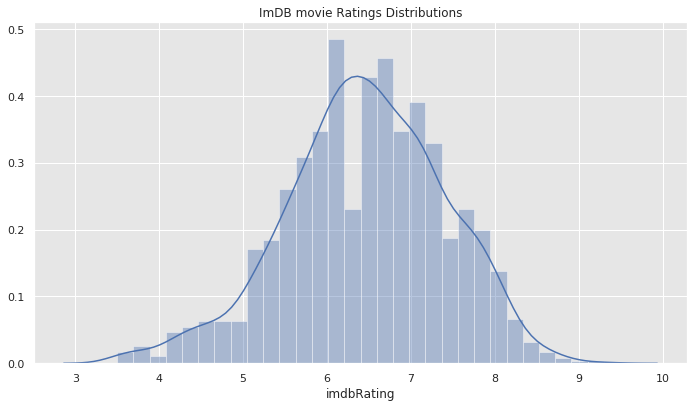

In [17]:
sns.set(font_scale=1)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

a4_dims = (11.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(Movies_Ratings.imdbRating)
plt.title("ImDB movie Ratings Distributions")

The 1810 movies pulled show a normal IMDB rating distribution from 3.5 to 9.

In [18]:
#Bar Char

Text(0.5, 1.0, 'imdb Rating Binning Distribution')

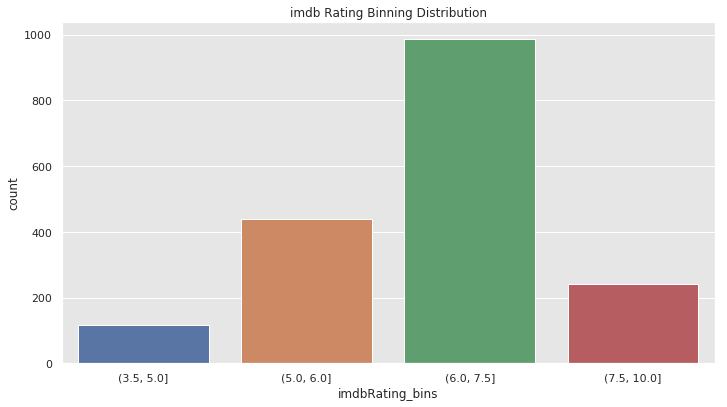

In [19]:
f, ax = plt.subplots(figsize=(11.7, 6.27))
sns.countplot(x="imdbRating_bins",  data=Movies_Ratings )
plt.title('imdb Rating Binning Distribution')

Most action movies have imdb ratings between 6 and 7.5

Text(0.5, 1.0, 'MetaScore Binning Distribution')

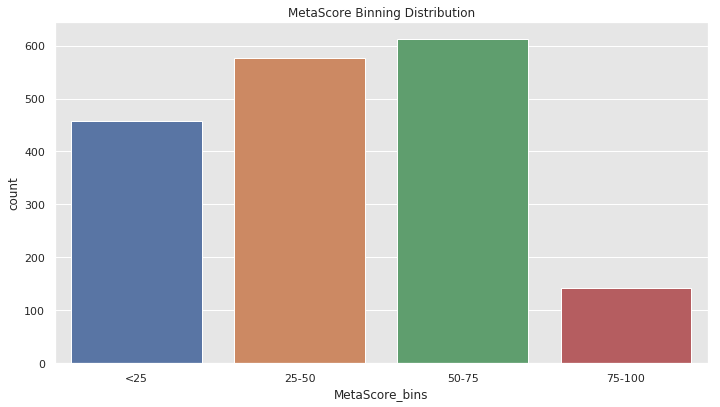

In [20]:
f, ax = plt.subplots(figsize=(11.7, 6.27))
sns.countplot(x="MetaScore_bins",  data=Movies_Ratings )
plt.title('MetaScore Binning Distribution')

Text(0.5, 1.0, 'Vote Count Distributions')

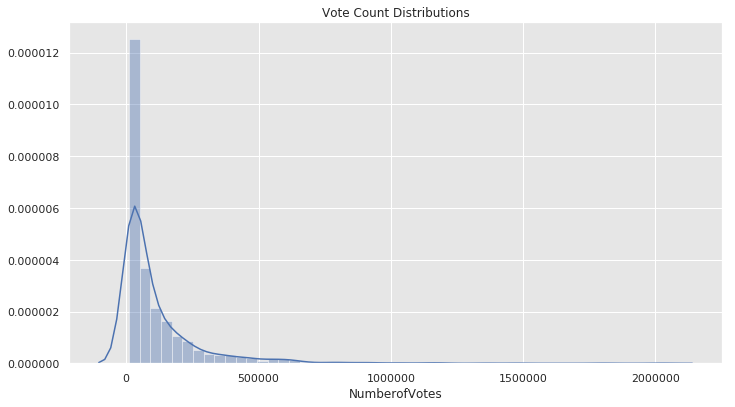

In [21]:
sns.set(font_scale=1)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

a4_dims = (11.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(Movies_Ratings.NumberofVotes)
plt.title("Vote Count Distributions")

Most of the movies have votecounts less than 10000

In [22]:
# joint Plots

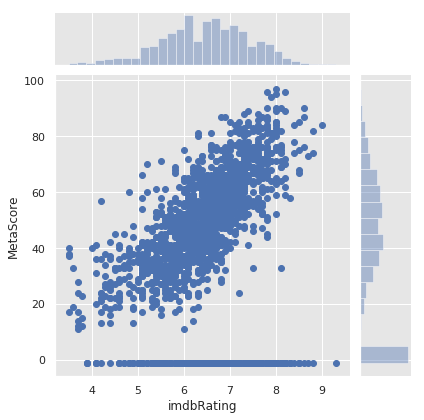

In [23]:
a4_dims = (11.7, 6.27)

sns.jointplot(x="imdbRating", y="MetaScore", data=Movies_Ratings);
#plt.title("Number of votes vs ImDB movie Ratings Distributions")

The is a strong positive correlation between imdbRating and movie Metascore as expected.

### Selecting movies to get reviews

I selected movies based on imdb rating. I treat movies with imdb Rating greater than 7.8 as best movies and those with imdb Rating <5.1 as worst movies generating a list og 119 best movies and 120 worst movies respectively

In [24]:
best_movies =Movies_Ratings[Movies_Ratings.imdbRating>7.8] # imDB Rating >7.8
worst_movies=Movies_Ratings[(Movies_Ratings.imdbRating<5.1)]  # imDB Rating<5

In [25]:
len(np.unique(best_movies.Title))#.shape

119

In [26]:
len((worst_movies.Title))#.shape

120

In [27]:
Best100_and_Worst100 = pd.concat([best_movies, worst_movies], ignore_index =True) # join the two 

In [28]:
Best100_and_Worst100=Best100_and_Worst100.reset_index()
#Best100_and_Worst100.pop("index")

In [29]:
Best100_and_Worst100.head()

,index,Title,imdbRating,NumberofVotes,MetaScore,Movie Page,Movie's Review Page,imdbRating_bins,MetaScore_bins
0,0,The Mountain II (2016) - IMDb,9.3,99822,-1,https://www.imdb.com/title/tt5813916/?ref_=adv...,https://www.imdb.com/title/tt5813916/reviews?r...,"(7.5, 10.0]",<25
1,1,The Dark Knight (2008) - IMDb,9.0,2025570,84,https://www.imdb.com/title/tt0468569/?ref_=adv...,https://www.imdb.com/title/tt0468569/reviews?r...,"(7.5, 10.0]",75-100
2,2,Vikram Vedha (2017) - IMDb,8.8,17684,-1,https://www.imdb.com/title/tt6148156/?ref_=adv...,https://www.imdb.com/title/tt6148156/reviews?r...,"(7.5, 10.0]",<25
3,3,Inception (2010) - IMDb,8.8,1804838,74,https://www.imdb.com/title/tt1375666/?ref_=adv...,https://www.imdb.com/title/tt1375666/reviews?r...,"(7.5, 10.0]",75-100
4,4,Star Wars: Episode V - The Empire Strikes Back...,8.8,1033505,82,https://www.imdb.com/title/tt0080684/?ref_=adv...,https://www.imdb.com/title/tt0080684/reviews?r...,"(7.5, 10.0]",75-100


In [30]:
Best100_and_Worst100.shape

(239, 9)

### Pulling Movie from IMDB Reviews

Using the function below, I pull 25 reviews for the ~239 movies listed above. Along with the review I store, the review title, review Author, review date, review rating and store in a pandas dataframe for futher analysis

In [31]:
#Reference : https://stackoverflow.com/questions/47788605/how-to-use-python-to-press-the-load-more-in-imdb-to-get-more-reviews?noredirect=1&lq=1

import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup

def get_reviews(movie_title ="Place Holder",url = "https://www.imdb.com/title/tt1502712/reviews?ref_=tt_ql_3" ):
    '''
    Functions takes a reviews page url and returns a page df with 10 movie reviews
    '''
    Review_Title =[]
    Review_Author =[]
    Review_Date =[]
    Review_Rating =[]
    Review =[]
    Data_Reviews ={}
    
    res = requests.get(url)
    soup = BeautifulSoup(res.text,"lxml")

    main_content = urljoin(url,soup.select(".load-more-data")[0]['data-ajaxurl'])  ##extracting the link leading to the page containing everything available here
    response = requests.get(main_content)
    broth = BeautifulSoup(response.text,"lxml")

    for item in broth.select(".review-container"):
        #print(item)
        title = item.select(".title")[0].text.splitlines()
        Review_Title =Review_Title + title
        review = str(item.select(".text")[0].text)
        Review =Review +[review]
        try:
            score= item.select(".ipl-ratings-bar")[0].text.split('\n')[7]
            Review_Rating =Review_Rating +[score]
        except:
            score="?"
            Review_Rating =Review_Rating +[score]

        reviewer= item.select(".display-name-date")[0].text.split('\n')[1].split()[0]
        review_date= str(item.select(".display-name-date")[0].text.split('\n')[1].split()[1])+'/'+str(item.select(".display-name-date")[0].text.split('\n')[1].split()[2])
        Review_Author =Review_Author +[reviewer]
        Review_Date =Review_Date +[review_date]
    Data_Reviews.update({"Movie":movie_title, 
                         "Review_Title":Review_Title, 
                         "Review_Author":Review_Author,
                         "Review_Date":Review_Date,
                         "Review_Rating":Review_Rating,
                         "Review":Review}) 
    return(pd.DataFrame.from_dict(Data_Reviews))

I have commented code block below to avoid re-rerunning reviews Query. Below I tag review with Ratings greater than 6/10 as positive (1) and the rest as Negative (0)

In [32]:
'''
Reviews_perMovie = pd.DataFrame() #25 reviews per movie
for i in range(Best100_and_Worst100.shape[0]):
    #Title =Best100_and_Worst100.Title[i]
    try:
        temp =get_reviews(movie_title =Best100_and_Worst100["Title"][i], url = Best100_and_Worst100["Movie's Review Page"][i])
        Reviews_perMovie =pd.concat([Reviews_perMovie, temp], ignore_index =False)
        print(i, Best100_and_Worst100["Title"][i], 'success!!!')
    except:
        print('fail')

#### create review rating 1 for positve 0 for negative
Reviews_perMovie = Reviews_perMovie[Reviews_perMovie.Review_Rating!= "?"] # drop row whos review rating ins ?
Reviews_perMovie = Reviews_perMovie.assign(Rating = np.where(Reviews_perMovie['Review_Rating'].isin(['10/10','8/10', '9/10', '6/10', '7/10']), 1, 0))
Final_Movie_List =pd.DataFrame()
for i in np.unique(Reviews_perMovie.Movie):
    Temp = Reviews_perMovie[Reviews_perMovie.Movie==i]
    #select one positive and one negative movie
    Temp_Positive = Temp[Temp.Rating==1]
    Temp_Negative = Temp[Temp.Rating==0]
    if(len(Temp_Positive)!=0 or len(Temp_Negative)!=0): #filter to only movies with a positive and negative review
        Final_Movie_List = pd.concat([Final_Movie_List,Temp_Positive.head(1)])
        Final_Movie_List = pd.concat([Final_Movie_List,Temp_Negative.head(1)])
        
#### Save final review dataframe list
pickle.dump(Final_Movie_List, open( "Final_Movie_List.p", "wb" ) , protocol=2)# save dataframe as pickle
'''

'\nReviews_perMovie = pd.DataFrame() #25 reviews per movie\nfor i in range(Best100_and_Worst100.shape[0]):\n    #Title =Best100_and_Worst100.Title[i]\n    try:\n        temp =get_reviews(movie_title =Best100_and_Worst100["Title"][i], url = Best100_and_Worst100["Movie\'s Review Page"][i])\n        Reviews_perMovie =pd.concat([Reviews_perMovie, temp], ignore_index =False)\n        print(i, Best100_and_Worst100["Title"][i], \'success!!!\')\n    except:\n        print(\'fail\')\n\n#### create review rating 1 for positve 0 for negative\nReviews_perMovie = Reviews_perMovie[Reviews_perMovie.Review_Rating!= "?"] # drop row whos review rating ins ?\nReviews_perMovie = Reviews_perMovie.assign(Rating = np.where(Reviews_perMovie[\'Review_Rating\'].isin([\'10/10\',\'8/10\', \'9/10\', \'6/10\', \'7/10\']), 1, 0))\nFinal_Movie_List =pd.DataFrame()\nfor i in np.unique(Reviews_perMovie.Movie):\n    Temp = Reviews_perMovie[Reviews_perMovie.Movie==i]\n    #select one positive and one negative movie\n    

### CODE that follows is run on python2.7 to take advantage of pattern for chunking

In [5]:
#final Review list
with open('Final_Movie_List.p', 'rb') as f:
     Final_Movie_List = pickle.load(f)
Final_Movie_List .head()

,Movie,Review_Title,Review_Author,Review_Date,Review_Rating,Review,Rating
0,1 - Nenokkadine (2014) - IMDb,Its like watching a color film during the bla...,s-vinaykumar12345610,January/2014,9/10,Its the same excitement that bring to every to...,1
0,24 (2016) - IMDb,Worth the TIME!!,naveensankaran186,May/2016,9/10,Vikram K Kumar is the real hero! All his work ...,1
20,24 (2016) - IMDb,Such a disappointment .....,tmyuran24,June/2016,5/10,This review is not intended to hurt anyone. I ...,0
0,A Sound of Thunder (2005) - IMDb,Best bad movie of the year!,mooshki3,September/2005,7/10,I live for movies like this.Saw it in a theate...,1
2,A Sound of Thunder (2005) - IMDb,Prepare to thunder towards the exit,TheMovieMark1,September/2005,4/10,What exactly is the sound of thunder? If this ...,0


The function below cleans the reviews from above dataframe, breaks review into tokens using the same approach as previous homeworks as shown in steps below and also chunks the sentences. I create two new columns the `Final_Movie_List` 'Tokens' and 'Chunks'

In [6]:
def Clean_Review_and_Chunk(raw):
    '''
    ** Function to clean, chunk and tokenize review **
    # Steps
    1. Break review into sentences/lines
    2. Change senteces to lower case
    3. Expland contractions for each sentence. Turning shortforms like Can't to Can not
    4. NP Chunk from pattern.en import parsetree 
    5. Break lines into tokens
    6.  Remove punctuation marks
    7. remove stopwords
    8. Perform lemmatization
    reference: https://nickcdryan.com/2017/02/13/shallow-parsing-for-entity-recognition-with-nltk-and-machine-learning/
    '''
    from pattern.en import parsetree 
    Tokens =[]
    Tree =[]
    Temp = list(raw.splitlines())
    Chunk = []
    Clean_Sentence =[]
    CleanTokens =[]
    
    for i in Temp:
        sentence = expand_contractions(i)#expand contractions
        Clean_Sentence = Clean_Sentence + [sentence.lower()]
        Tokens = Tokens + Tokenizer_Tool(sentence.lower(),'word_tokenize')#tokenize sentences
    words = [word for word in Tokens if word.isalpha()]#Remove punctuations
    CleanTokens = remove_stopwords(words)#Remove stopwords
    CleanTokens =lemming(CleanTokens) #Lemmetization of the tokens to get root words
    for i in Clean_Sentence: #Chunks sentences
        tree = parsetree(i)
        Tree = Tree + tree
    for sentence_tree in Tree: 
        Chunk = Chunk + sentence_tree.chunks 
    return Chunk, CleanTokens

In [7]:
#Sample chunked review and cleaned tokens
T, Tokens =Clean_Review_and_Chunk(list(Final_Movie_List.Review)[0])  
print(Tokens)
T

[u'excitement', u'bring', u'every', u'tollywood', u'movie', u'guy', u'watch', u'film', u'full', u'time', u'white', u'cinematography', u'usually', u'film', u'typically', u'nice', u'formula', u'start', u'fight', u'song', u'chase', u'villain', u'two', u'fight', u'joke', u'fight', u'climax', u'end', u'film', u'completely', u'different', u'film', u'could', u'set', u'standard', u'upcoming', u'one', u'completely', u'different', u'road', u'put', u'film', u'might', u'one', u'best', u'film', u'tollywood', u'make', u'script', u'till', u'end', u'like', u'movie', u'defines', u'law', u'physic', u'every', u'director', u'use', u'usual', u'formula', u'see', u'try', u'change', u'way', u'take', u'mr', u'sukumar', u'awesome', u'huge', u'leap', u'tollywood', u'excellent', u'cinematography', u'excellent', u'script', u'thou', u'loosen', u'bit', u'middle', u'excellent', u'direction', u'stun', u'background', u'music', u'good', u'crew', u'must', u'also', u'appreciate', u'background', u'music', u'mr', u'devi', u

[Chunk('its the same excitement/NP'),
 Chunk('bring/VP'),
 Chunk('to/PP'),
 Chunk('every tollywood movie guy/NP'),
 Chunk('when/ADVP'),
 Chunk('they/NP'),
 Chunk('have watched/VP'),
 Chunk('a film/NP'),
 Chunk('in/PP'),
 Chunk('full/NP'),
 Chunk('color/NP'),
 Chunk(''/VP'),
 Chunk('during/PP'),
 Chunk('the times/NP'),
 Chunk('of/PP'),
 Chunk('black/ADJP'),
 Chunk('white/NP'),
 Chunk('cinematography/NP'),
 Chunk('usually most/ADVP'),
 Chunk('of/PP'),
 Chunk(''/VP'),
 Chunk('tollywood/NP'),
 Chunk('films/NP'),
 Chunk('has/VP'),
 Chunk('typically/ADVP'),
 Chunk('a nice formulae/NP'),
 Chunk('start/VP'),
 Chunk('with/PP'),
 Chunk('a fight/NP'),
 Chunk('a song/NP'),
 Chunk('chase/VP'),
 Chunk('the villains/NP'),
 Chunk('two more fights/NP'),
 Chunk('10 jokes/NP'),
 Chunk('fight/NP'),
 Chunk('in/PP'),
 Chunk('climax and end/NP'),
 Chunk('this film/NP'),
 Chunk('is/VP'),
 Chunk('completely different/ADJP'),
 Chunk('a film/NP'),
 Chunk('could set/VP'),
 Chunk('standards/NP'),
 Chunk('to/PP'),


In [8]:
import copy
Chunks = []
Tokens =[]
for i in list(Final_Movie_List.Review):
    try:
        chunk, token =Clean_Review_and_Chunk(i)
        Chunks.append(chunk)
        Tokens.append(token)
    except:
        print('failed to Chunk!!! Attaching empty string')
        Chunks.append("")
        Tokens.append("")
Final_Movie_List['Tokens'] = Tokens
Final_Movie_List['Chunks'] = Chunks
Final_Movie_List =Final_Movie_List.reset_index()
del Final_Movie_List['index']        
    

failed to Chunk!!! Attaching empty string


In [9]:
Final_Movie_List.tail(4)

,Movie,Review_Title,Review_Author,Review_Date,Review_Rating,Review,Rating,Tokens,Chunks
383,Zoom (2006) - IMDb,Classic slapstick Allen and Chase,DocVW15,February/2007,8/10,I actually watched this movie before I read an...,1,"[actually, watch, movie, read, review, comment...","[i, actually watched, this movie, before, i re..."
384,Zoom (2006) - IMDb,"Oh, for a kid's movie, you need to give it a ...",Smells_Like_Cheese27,February/2007,5/10,"I rented this movie for my cousin, it was his ...",0,"[rent, movie, cousin, pick, watch, soon, get, ...","[i, rented, this movie, for, my cousin, it, wa..."
385,xXx: State of the Union (2005) - IMDb,Action-packed!!!,darkstar_ae16,May/2005,7/10,"From the creators of ""Die Another Day""! XXX: T...",1,"[creator, die, another, day, xxx, next, level,...","[from, the creators, of, die, another day, xxx..."
386,xXx: State of the Union (2005) - IMDb,xXx2: Coma State,pkeevers30,April/2005,2/10,A film that should be retitled xXx2: Don't Say...,0,"[film, retitled, say, warn, impressive, first,...","[a film, that should be retitled, do not say, ..."


In [10]:
### Save final review dataframe list
pickle.dump(Final_Movie_List, open( "Final_Movie_List_clean.p", "wb" ) , protocol=2)# save dataframe as pickle

In [11]:
import pickle
with open('Final_Movie_List_clean.p', 'rb') as f:
     Final_Movie_List_clean = pickle.load(f)

In [12]:
Final_Movie_List_clean.shape

(387, 9)

A total os 387 reviews were pulled. one movie did not have a negative review (review <5)

Movie chunks are saved in pandas object for future labs. below I diplay some sample movie reviews chunks.

In [13]:
print("############### Sampled Chunks ##################")
for i in range(6,10):
    print('---------------------------------------------------------------------------------------------------')
    print('Movie Title :',Final_Movie_List_clean.Movie[i], "Postive = 1/ Negative = 0, Review Rating: ", Final_Movie_List_clean.Rating[i] )
    print('---------------------------------------------------------------------------------------------------')
    print(Final_Movie_List_clean.Chunks[i])

############### Sampled Chunks ##################
---------------------------------------------------------------------------------------------------
('Movie Title :', u'Aftershock (2012) - IMDb', 'Postive = 1/ Negative = 0, Review Rating: ', 1)
---------------------------------------------------------------------------------------------------
[Chunk('i/NP'), Chunk('would not call/VP'), Chunk('this a horror film/NP'), Chunk('a dark disaster film/NP'), Chunk('is/VP'), Chunk('more appropriate/ADJP'), Chunk('the film/NP'), Chunk('is fun/VP'), Chunk('lively/ADJP'), Chunk('well done/VP'), Chunk('acted/VP'), Chunk('if/PP'), Chunk('not/ADVP'), Chunk('for/PP'), Chunk('oddly timed/VP'), Chunk('inappropriate character reveal/NP'), Chunk('just makes/VP'), Chunk('you/NP'), Chunk('scratch/VP'), Chunk('your head/NP'), Chunk('go/VP'), Chunk('it/NP'), Chunk('was fun/VP'), Chunk('reveal/ADJP'), Chunk('was not even needed/VP'), Chunk('especially when/ADVP'), Chunk('it/NP'), Chunk('did happen/VP'), Chunk

In [2]:
%load_ext version_information
%version_information pandas, numpy, nltk, re, contractions, pattern3, requests, bs4, selenium, lxml, urllib3, pyvirtualdisplay, spacy

Software,Version
Python,3.6.8 64bit [GCC 7.3.0]
IPython,7.2.0
OS,Linux 4.15.0 46 generic x86_64 with debian buster sid
pandas,0.24.1
numpy,1.16.1
nltk,3.4
re,2.2.1
contractions,0.0.17
pattern3,2.6
requests,2.21.0
